In [1]:
library(tidyverse)
library(glmnet)

# Custom package
library(rutils)

-- Attaching packages ------------------------------------------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.0.6     v dplyr   1.0.4
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Loaded glmnet 4.1



In [2]:
# Define constants
dirs <- rutils::get_dev_directories(dev_paths_file = "../dev_paths.txt")
projects <- c("TCGA-CESC", "TCGA-UCS", "TCGA-UCEC", "TCGA-OV")
unified_dsets <- c("unified_cervical_data", "unified_uterine_data", "unified_uterine_endometrial_data")
matrisome_path <- paste0(dirs$data_dir, "/matrisome/matrisome_hs_masterlist.tsv")

event_code <- list("Alive" = 0, "Dead" = 1)
# covariate_cols <- c("figo_stage", "age_at_diagnosis", "race", "ethnicity")
dep_cols <- c("vital_status", "survival_time")

In [3]:
dset_idx <- 3
save_res <- TRUE

In [4]:
# Load and filter survival data
survival_path <- paste0(dirs$data_dir, "/", unified_dsets[dset_idx], "/survival_data.tsv")
survival_df <- load_survival_df(survival_path, event_code)
umsmg_demg_list <- read_lines(paste0(dirs$analysis_dir, "/gene_lists/", unified_dsets[dset_idx], "_umsmg_demg_list.txt"))
cutoff_df <- read_tsv(paste0(dirs$analysis_dir, "/survival/", unified_dsets[dset_idx], "_expression_cutoffs.tsv"))

filtered_survival_df <- survival_df %>%
    dplyr::select(one_of(c("sample_name", dep_cols))) %>%
    dplyr::filter(rowSums(is.na(.)) == 0)

# Load normalized matrisome count data
norm_matrisome_counts_df <- read_tsv(paste0(dirs$data_dir, "/", unified_dsets[dset_idx], "/norm_matrisome_counts.tsv"))
norm_matrisome_counts_t_df <- norm_matrisome_counts_df %>%
    dplyr::select(c("geneID", filtered_survival_df$sample_name)) %>%
    transpose_df("geneID", "sample_name")
# Combine survival data and normalized count data
filtered_joined_df <- filtered_survival_df %>%
    inner_join(norm_matrisome_counts_t_df, by = "sample_name") %>%
#     select(one_of("sample_name", "vital_status", "survival_time", umsmg_demg_list)) %>%
    # cannot have survival times of 0
    dplyr::filter(survival_time > 0)


-- Column specification ------------------------------------------------------------------------------------------------------------------------
cols(
  sample_name = col_character(),
  vital_status = col_character(),
  survival_time = col_double(),
  figo_stage = col_character(),
  days_to_last_follow_up = col_double(),
  days_to_death = col_double(),
  age_at_diagnosis = col_double(),
  age_at_index = col_double(),
  height = col_double(),
  weight = col_double(),
  bmi = col_double(),
  race = col_character(),
  ethnicity = col_character()
)



-- Column specification ------------------------------------------------------------------------------------------------------------------------
cols(
  geneID = col_character(),
  cutoff = col_double()
)



-- Column specification ------------------------------------------------------------------------------------------------------------------------
cols(
  .default = col_double(),
  geneID = col_character()
)
i Use `spec()` for the full co

In [5]:
y <- as.matrix(
    filtered_joined_df %>%
        dplyr::select(survival_time, vital_status) %>%
        dplyr::rename(time = survival_time, status = vital_status)
)
rownames(y) <- filtered_joined_df$sample_name

x <- as.matrix(
    filtered_joined_df %>%
        dplyr::select(-c(sample_name, vital_status, survival_time))
)
rownames(x) <- filtered_joined_df$sample_name

In [6]:
set.seed(123)
# alpha = 1 --> lasso
# cv_cph_model <- cv.glmnet(x, y, family = "cox", alpha = 0.5, type.measure = "default")
cv_cph_model <- cv.glmnet(x, y, family = "cox", alpha = 1, nfolds = 10, type.measure = "C")
# cph_model <- glmnet(x, y, family = "cox", alpha = 1)


Call:  cv.glmnet(x = x, y = y, type.measure = "C", nfolds = 10, family = "cox",      alpha = 1) 

Measure: C-index 

     Lambda Index Measure      SE Nonzero
min 0.02792    34  0.7795 0.04645      40
1se 0.05878    18  0.7336 0.03943      19

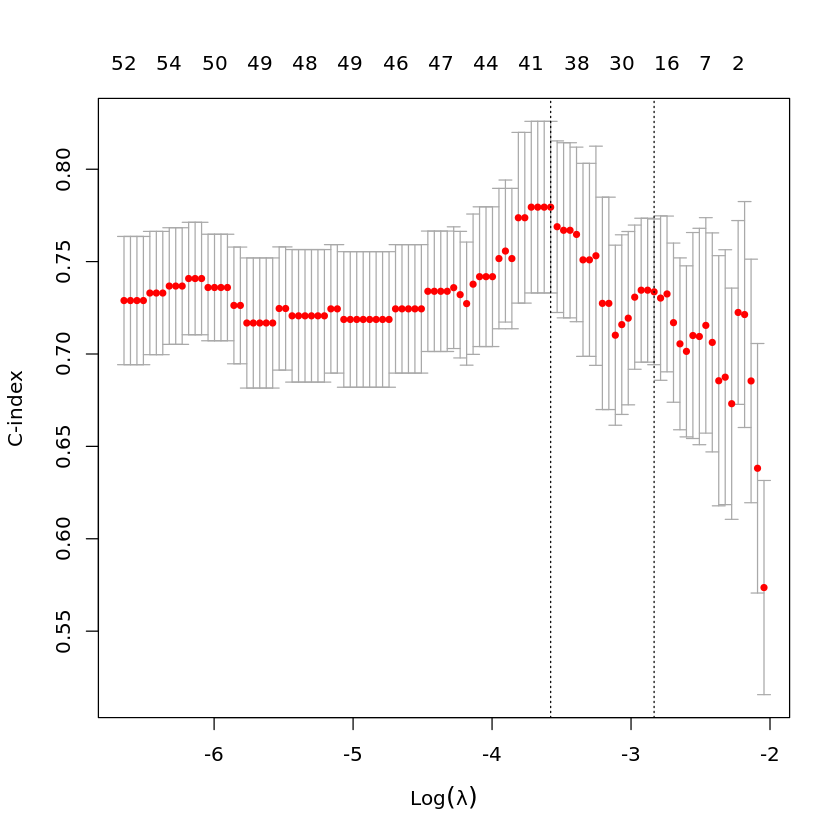

In [7]:
cv_cph_model
plot(cv_cph_model)

In [8]:
# Index associated with best cv performance
# cv_min_idx <- cv_cph_model$index["min",]
cv_min_idx <- cv_cph_model$index["1se",]
# best cv performance
cv_best_cvm <- cv_cph_model$cvm[cv_min_idx]
# Std. error assoc. with best cv performance
cv_best_se <- cv_cph_model$cvsd[cv_min_idx]
# model_mask <- cv_cph_model$cvm > cv_best_cvm - cv_best_se
# model_mask <- cv_cph_model$cvm < cv_best_cvm + cv_best_se

# model_mask <- cv_cph_model$cvm == cv_best_cvm
# mask_lambda <- cv_cph_model$lambda[model_mask] %>% last()
# mask_lambda_genes <- as.matrix(coef(cv_cph_model, s = mask_lambda))[, 1] != 0
# mask_lambda <- cv_cph_model$lambda.min
mask_lambda <- cv_cph_model$lambda[cv_min_idx]
mask_lambda_genes <- as.matrix(coef(cv_cph_model, s = mask_lambda))[, 1] != 0

In [9]:
cv_cph_model_coeffs <- as.matrix(coef(cv_cph_model, s = mask_lambda))
important_gene_df <- tibble(geneID = colnames(x)[mask_lambda_genes], coeff = cv_cph_model_coeffs[mask_lambda_genes])
important_gene_df

geneID,coeff
<chr>,<dbl>
FGF16,0.211350058
CHAD,0.009551597
PF4V1,0.013738928
PRG3,1.185821289
RSPO2,0.199427136
WIF1,-0.184009240
SERPINB2,0.025650788
CSH1,0.624011971
FREM3,0.056595010


In [10]:
if (save_res) {
    write_tsv(important_gene_df, paste0(dirs$analysis_dir, "/survival/", unified_dsets[dset_idx], "_en_cph_results.tsv"))    
}